In [21]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as m_a_e, mean_squared_error as m_s_e, r2_score as r2
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lime import lime_tabular

from scipy.stats.mstats import winsorize

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
dataset = "E:/Formation Data Scientist/Projet_4/2016_Building_Energy_Benchmarking.csv"

In [24]:
df = pd.read_csv(dataset)

## <a name='C2'> EDA et Choix des features   </a>

In [25]:
df.head(3)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [27]:
df.shape

(3376, 46)

- Exploration des valeurs nulles

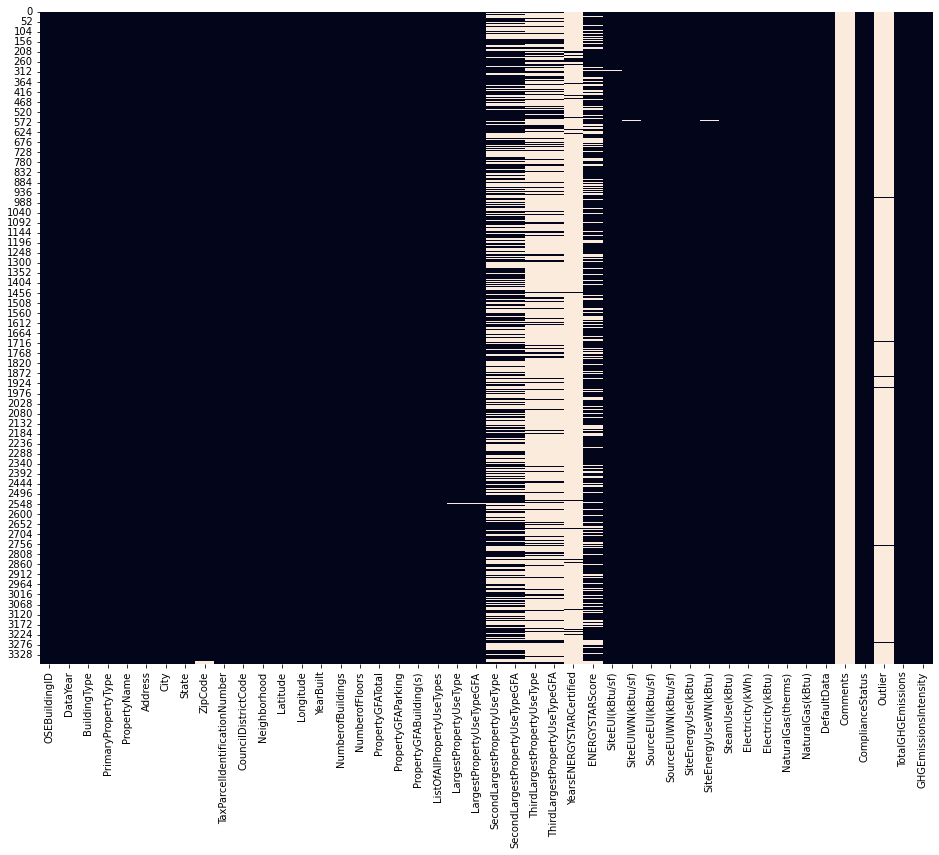

In [28]:
plt.figure(figsize=(16,12))
sns.heatmap(df.isna(),cbar=False)
plt.show()

La trame de données est plutot bien remplie, la plupart des colonnes ne possèdent pas ou très peu de valeures nulles

- Typologie des variables

In [29]:
df.dtypes.value_counts()

float64    22
object     15
int64       8
bool        1
dtype: int64

- Exploration des varibles catégoriques

In [30]:
df_cat = df.select_dtypes(include='object').copy()
df_cat.head(1)

,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,TaxParcelIdentificationNumber,Neighborhood,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearsENERGYSTARCertified,ComplianceStatus,Outlier
0,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,0659000030,DOWNTOWN,Hotel,Hotel,NaN,NaN,NaN,Compliant,NaN


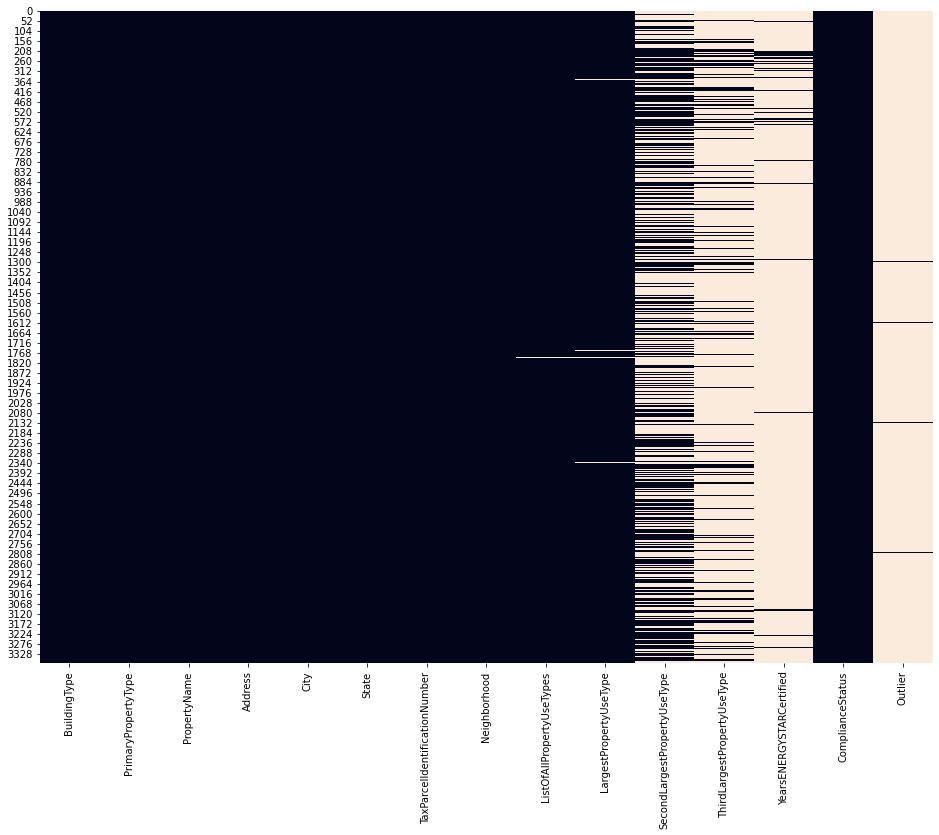

In [31]:
plt.figure(figsize=(16,12))
sns.heatmap(df_cat.isna(),cbar=False)
plt.show()

- BoxPlot des targets

<AxesSubplot:xlabel='SiteEnergyUse(kBtu)'>

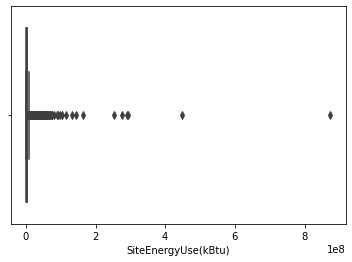

In [32]:
sns.boxplot(x=df['SiteEnergyUse(kBtu)'])

<AxesSubplot:xlabel='TotalGHGEmissions'>

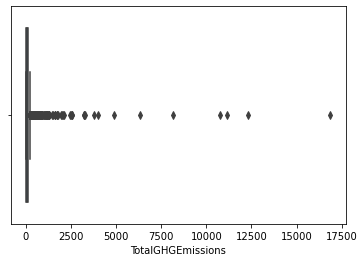

In [33]:
sns.boxplot(x=df['TotalGHGEmissions'])

Nous avons un certains nombre de valeurs de consommation d'énergie et émission de CO2 pouvant être considéré comme outliers

- Boxplot de la consommation en energie des differents types de building 

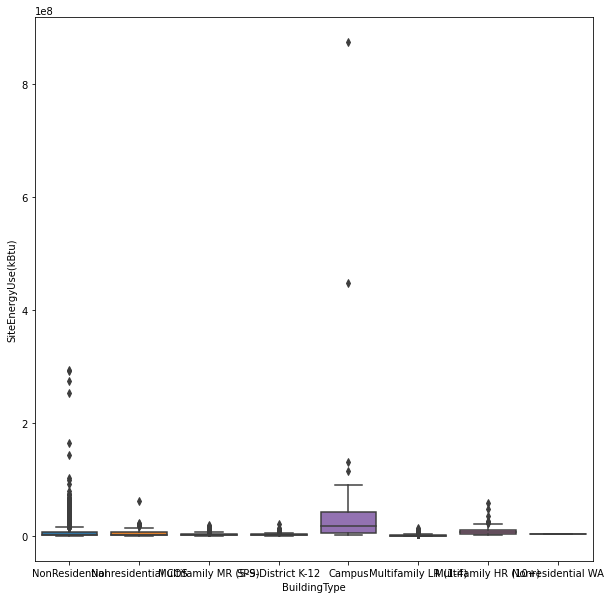

In [34]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df, x='BuildingType',y='SiteEnergyUse(kBtu)')
plt.show()

- Boxplot des émissions de CO2 des differents types de building 

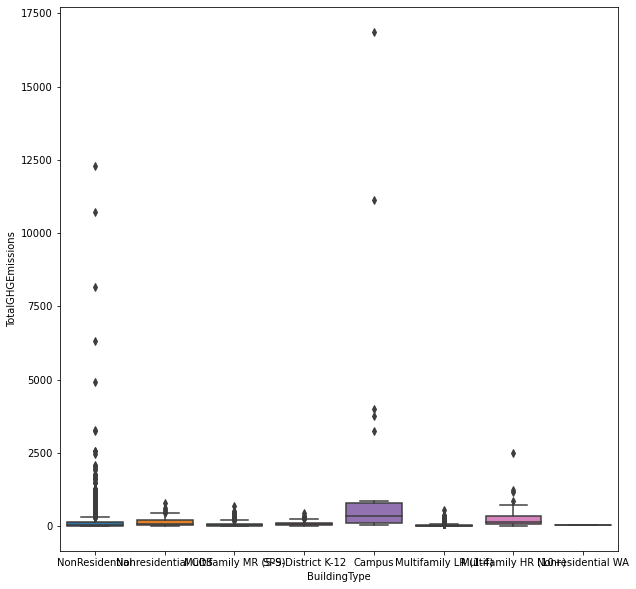

In [35]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df, x='BuildingType',y='TotalGHGEmissions')
plt.show()

- Exploration des Outliers

In [36]:
df['Outlier'].value_counts()

Low outlier     23
High outlier     9
Name: Outlier, dtype: int64

In [37]:
df['ComplianceStatus'].value_counts()

Compliant                       3211
Error - Correct Default Data     113
Non-Compliant                     37
Missing Data                      15
Name: ComplianceStatus, dtype: int64

On a 8 types de buiding, seuls les buildings non résidentiels nous interressent dans le cadre de notre étude

In [38]:
df.iloc[:,2].value_counts()

NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: BuildingType, dtype: int64

## <a name='C2'> Feature Engineering   </a>

- Création d'une trame contenant les batiments non résidentiels

In [39]:
building_type = ['NonResidential','NonResidential COS','NonResidential WA','Campus','SPS-District K-12'] 

nonRes = df[df['BuildingType'].isin(building_type)].reset_index(drop=True)

- Nos deux targets sont **TotalGHGEmissions** et **SiteEnergyUse(kBtu)**

- Sélection des batiments compliants aux normes

In [40]:
compliant = ['Compliant']

nonRes = nonRes[nonRes['ComplianceStatus'].isin(compliant)].reset_index(drop=True)

In [41]:
nonRes.shape

(1466, 46)

In [42]:
nonRes.head(1)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1156514.25,3946027.0,12764.5293,1276453.0,False,NaN,Compliant,NaN,249.98,2.83


- Boxplot des batiments d'interets

<AxesSubplot:xlabel='BuildingType', ylabel='SiteEnergyUse(kBtu)'>

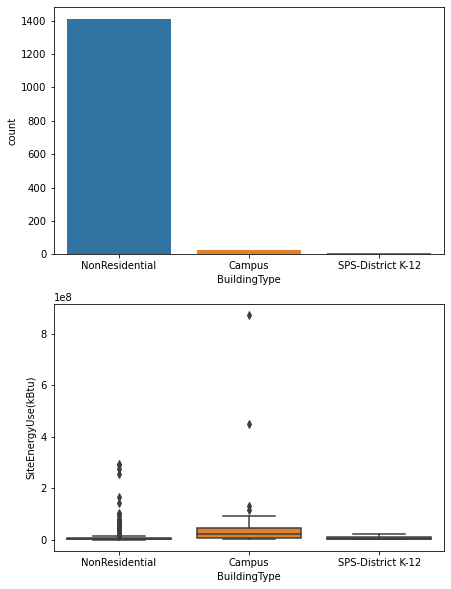

In [102]:
fig = plt.figure(figsize=(7,10))

ax1 = fig.add_subplot(2,1,1) 
sns.countplot(data = nonRes, x = 'BuildingType', ax = ax1)

ax2 = fig.add_subplot(2,1,2) 
sns.boxplot(data = nonRes, x='BuildingType', y='SiteEnergyUse(kBtu)' , ax = ax2)

In [103]:
""" plt.figure(figsize=(10,10))
sns.boxplot(data=nonRes, x='BuildingType',y='SiteEnergyUse(kBtu)')
plt.show() """

" plt.figure(figsize=(10,10))\nsns.boxplot(data=nonRes, x='BuildingType',y='SiteEnergyUse(kBtu)')\nplt.show() "

<AxesSubplot:xlabel='SiteEnergyUse(kBtu)', ylabel='PrimaryPropertyType'>

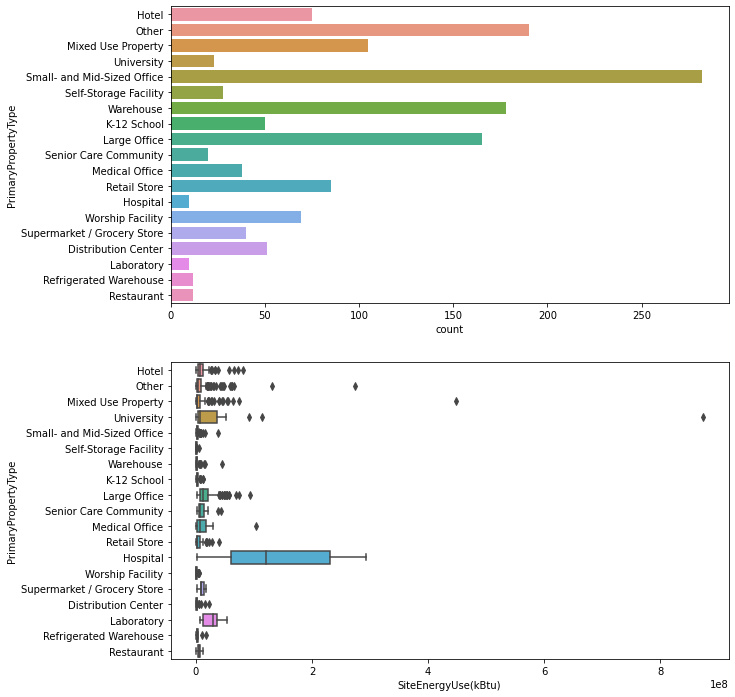

In [100]:
fig = plt.figure(figsize=(10,12))

ax1 = fig.add_subplot(2,1,1) 
sns.countplot(data = nonRes, y = 'PrimaryPropertyType', ax = ax1)

ax2 = fig.add_subplot(2,1,2) 
sns.boxplot(data = nonRes, y='PrimaryPropertyType', x='SiteEnergyUse(kBtu)' , ax = ax2)

In [104]:
""" plt.figure(figsize=(10,10))
sns.boxplot(data=nonRes, y='PrimaryPropertyType',x='SiteEnergyUse(kBtu)')
plt.show() """

" plt.figure(figsize=(10,10))\nsns.boxplot(data=nonRes, y='PrimaryPropertyType',x='SiteEnergyUse(kBtu)')\nplt.show() "

<AxesSubplot:xlabel='BuildingType', ylabel='TotalGHGEmissions'>

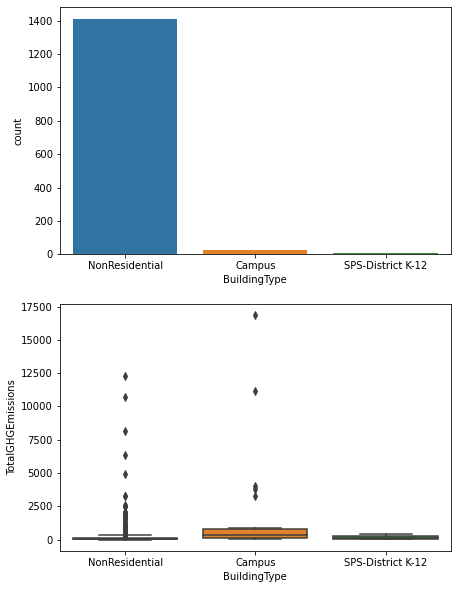

In [105]:
fig = plt.figure(figsize=(7,10))

ax1 = fig.add_subplot(2,1,1) 
sns.countplot(data = nonRes, x = 'BuildingType', ax = ax1)

ax2 = fig.add_subplot(2,1,2) 
sns.boxplot(data = nonRes, x='BuildingType', y='TotalGHGEmissions' , ax = ax2)

In [106]:
""" plt.figure(figsize=(10,10))
sns.boxplot(data=nonRes, x='BuildingType',y='TotalGHGEmissions')
plt.show() """

" plt.figure(figsize=(10,10))\nsns.boxplot(data=nonRes, x='BuildingType',y='TotalGHGEmissions')\nplt.show() "

<AxesSubplot:xlabel='TotalGHGEmissions', ylabel='PrimaryPropertyType'>

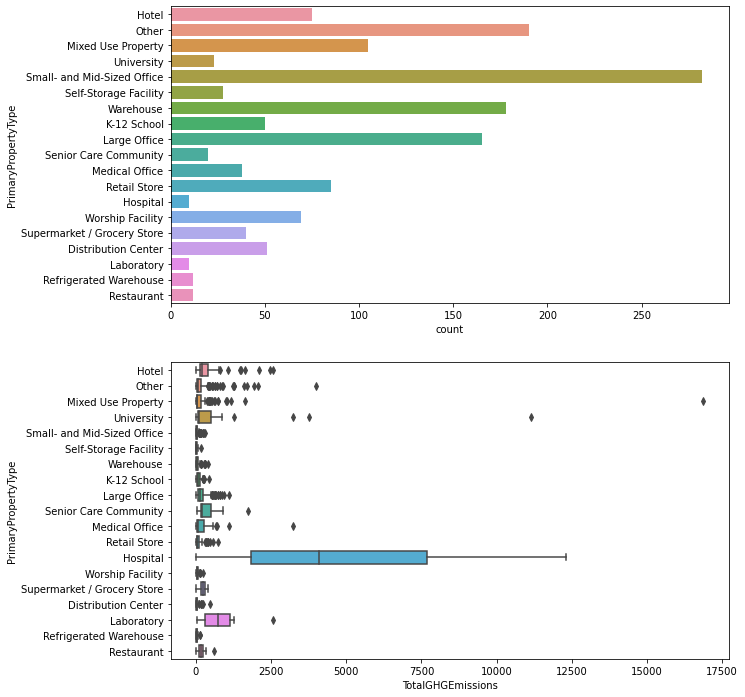

In [107]:
fig = plt.figure(figsize=(10,12))

ax1 = fig.add_subplot(2,1,1) 
sns.countplot(data = nonRes, y = 'PrimaryPropertyType', ax = ax1)

ax2 = fig.add_subplot(2,1,2) 
sns.boxplot(data = nonRes, y='PrimaryPropertyType', x='TotalGHGEmissions' , ax = ax2)

In [108]:
""" plt.figure(figsize=(10,10))
sns.boxplot(data=nonRes, y='PrimaryPropertyType',x='TotalGHGEmissions')
plt.show() """

" plt.figure(figsize=(10,10))\nsns.boxplot(data=nonRes, y='PrimaryPropertyType',x='TotalGHGEmissions')\nplt.show() "

In [45]:
nonRes.iloc[:,3].value_counts()

Small- and Mid-Sized Office    282
Other                          190
Warehouse                      178
Large Office                   165
Mixed Use Property             105
Retail Store                    85
Hotel                           75
Worship Facility                69
Distribution Center             51
K-12 School                     50
Supermarket / Grocery Store     40
Medical Office                  38
Self-Storage Facility           28
University                      23
Residence Hall                  21
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Low-Rise Multifamily             2
Name: PrimaryPropertyType, dtype: int64

- Nettoyage 

In [46]:
nonRes = nonRes.drop(nonRes[nonRes['PrimaryPropertyType'] == 'Low-Rise Multifamily'].index)
nonRes = nonRes.drop(nonRes[nonRes['PrimaryPropertyType'] == 'Residence Hall'].index)
#nonRes = nonRes.drop(nonRes[nonRes['PrimaryPropertyType'] == 'Other'].index)

In [47]:
nonRes['ComplianceStatus'].value_counts()

Compliant    1443
Name: ComplianceStatus, dtype: int64

In [48]:
nonRes['Outlier'].value_counts()

Series([], Name: Outlier, dtype: int64)

- Selection des mésures n'ayant pas été flagger comme outliers

In [49]:
nonRes = nonRes[nonRes.Outlier.isnull()]

- Sélection des Features

In [51]:
nonResidential = nonRes[['PrimaryPropertyType','Latitude','Longitude','YearBuilt','NumberofBuildings','NumberofFloors','ENERGYSTARScore'\
            ,'PropertyGFABuilding(s)','PropertyGFAParking','LargestPropertyUseTypeGFA','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','TotalGHGEmissions','SiteEnergyUse(kBtu)']]

- Crossplot Energie et émissions CO2

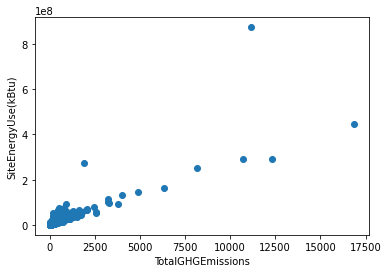

In [53]:
plt.scatter(nonResidential['TotalGHGEmissions'],nonResidential['SiteEnergyUse(kBtu)'])
plt.xlabel('TotalGHGEmissions')
plt.ylabel('SiteEnergyUse(kBtu)')
plt.show()

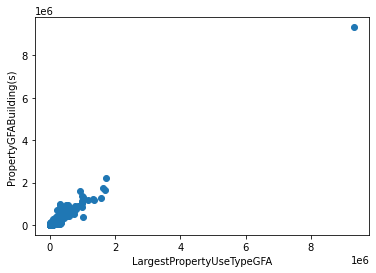

In [54]:
plt.scatter(nonResidential['LargestPropertyUseTypeGFA'],nonResidential['PropertyGFABuilding(s)'])
plt.xlabel('LargestPropertyUseTypeGFA')
plt.ylabel('PropertyGFABuilding(s)')
plt.show()

In [55]:
nonResidential[nonResidential['SiteEnergyUse(kBtu)'] > 200000000]
# Index des outliers à virer: 1443, 475,28

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,ENERGYSTARScore,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,SiteEnergyUse(kBtu)
28,Mixed Use Property,47.534930,-122.317880,1992,1.0,3,8.0,494835,0,757027.0,0.0,150476283.0,297909000.0,16870.98,448385312.0
92,Hospital,47.662310,-122.281460,1953,6.0,10,10.0,879000,0,879000.0,0.0,115641210.0,138191238.0,8145.52,253832464.0
117,Hospital,47.603990,-122.323770,2000,9.0,8,29.0,1158691,0,1350182.0,122575032.0,168683602.0,1832129.0,10734.57,293090784.0
475,Other,47.614380,-122.338710,1981,1.0,33,98.0,429405,0,218997.0,0.0,274532495.0,149672.0,1921.82,274682208.0
532,Hospital,47.608951,-122.322402,1994,7.0,14,54.0,1765970,0,1639334.0,134943456.0,139354828.0,17316120.0,12307.16,291614432.0
1443,University,47.656440,-122.310410,1900,111.0,0,NaN,9320156,0,9320156.0,84985240.0,657074389.0,0.0,11140.56,873923712.0


- Drop des Outliers

In [56]:
nonResidential[nonResidential['TotalGHGEmissions'] > 10000]

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,ENERGYSTARScore,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,SiteEnergyUse(kBtu)
28,Mixed Use Property,47.534930,-122.317880,1992,1.0,3,8.0,494835,0,757027.0,0.0,150476283.0,297909000.0,16870.98,448385312.0
117,Hospital,47.603990,-122.323770,2000,9.0,8,29.0,1158691,0,1350182.0,122575032.0,168683602.0,1832129.0,10734.57,293090784.0
532,Hospital,47.608951,-122.322402,1994,7.0,14,54.0,1765970,0,1639334.0,134943456.0,139354828.0,17316120.0,12307.16,291614432.0
1443,University,47.656440,-122.310410,1900,111.0,0,NaN,9320156,0,9320156.0,84985240.0,657074389.0,0.0,11140.56,873923712.0


In [41]:
# suppression des valeurs GHGE > 10000
#nonResidential = nonResidential[nonResidential['TotalGHGEmissions'] < 10000]

In [42]:
# suppression des valeurs energy > 600000000
#nonResidential = nonResidential[nonResidential['SiteEnergyUse(kBtu)'] < 250000000]

In [57]:
nonResidential = nonResidential.drop([1443, 475,28], axis = 0)

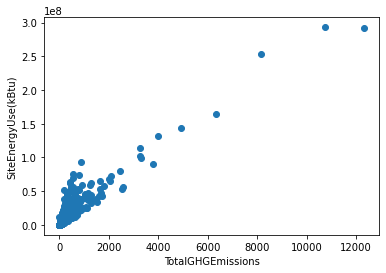

In [58]:
plt.scatter(nonResidential['TotalGHGEmissions'],nonResidential['SiteEnergyUse(kBtu)'])
plt.xlabel('TotalGHGEmissions')
plt.ylabel('SiteEnergyUse(kBtu)')
plt.show()

- Boxplot après drop des Outliers

<AxesSubplot:xlabel='SiteEnergyUse(kBtu)', ylabel='PrimaryPropertyType'>

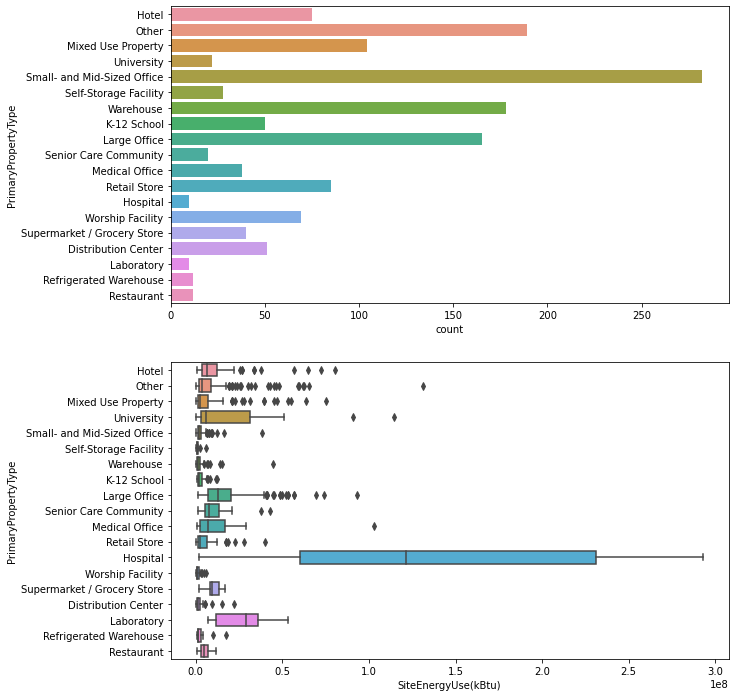

In [110]:
fig = plt.figure(figsize=(10,12))

ax1 = fig.add_subplot(2,1,1) 
sns.countplot(data = nonResidential, y = 'PrimaryPropertyType', ax = ax1)

ax2 = fig.add_subplot(2,1,2) 
sns.boxplot(data = nonResidential, y='PrimaryPropertyType', x='SiteEnergyUse(kBtu)' , ax = ax2)

<AxesSubplot:xlabel='TotalGHGEmissions', ylabel='PrimaryPropertyType'>

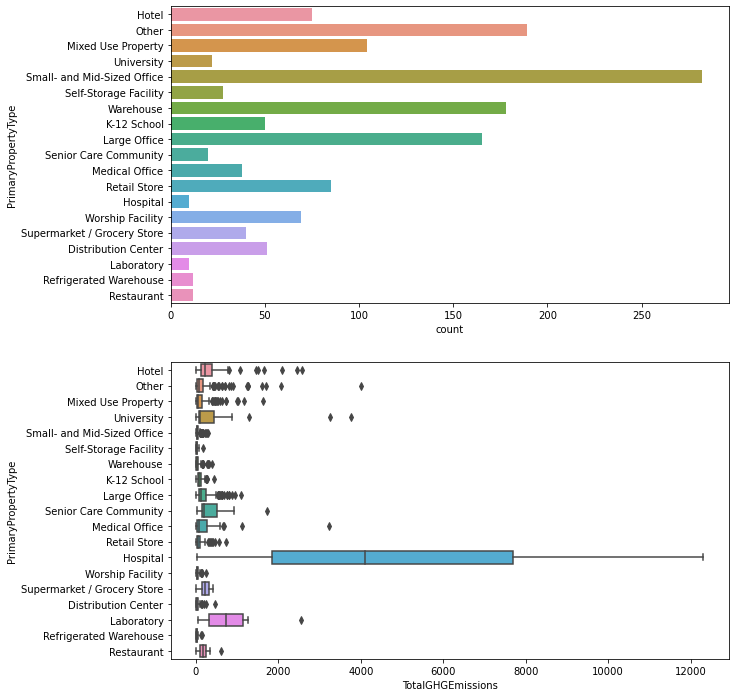

In [109]:
fig = plt.figure(figsize=(10,12))

ax1 = fig.add_subplot(2,1,1) 
sns.countplot(data = nonResidential, y = 'PrimaryPropertyType', ax = ax1)

ax2 = fig.add_subplot(2,1,2) 
sns.boxplot(data = nonResidential, y='PrimaryPropertyType', x='TotalGHGEmissions' , ax = ax2)

In [59]:
nonResidential.isna().sum()

PrimaryPropertyType            0
Latitude                       0
Longitude                      0
YearBuilt                      0
NumberofBuildings              0
NumberofFloors                 0
ENERGYSTARScore              473
PropertyGFABuilding(s)         0
PropertyGFAParking             0
LargestPropertyUseTypeGFA      4
SteamUse(kBtu)                 0
Electricity(kBtu)              0
NaturalGas(kBtu)               0
TotalGHGEmissions              0
SiteEnergyUse(kBtu)            0
dtype: int64

In [60]:
nonResidential[nonResidential['LargestPropertyUseTypeGFA'].isna()]

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,ENERGYSTARScore,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,SiteEnergyUse(kBtu)
281,Self-Storage Facility,47.66838,-122.39310,1946,2.0,2,NaN,111445,0,NaN,0.0,3007514.0,2689958.0,163.83,5.697472e+06
726,Hotel,47.61203,-122.34165,1910,1.0,8,93.0,61721,0,NaN,0.0,2534592.0,362488.0,36.92,2.897080e+06
1201,Small- and Mid-Sized Office,47.64747,-122.34086,2008,1.0,4,45.0,48350,0,NaN,0.0,3168131.0,0.0,22.09,3.168131e+06
1217,Restaurant,47.59697,-122.32474,1913,1.0,3,NaN,28800,0,NaN,0.0,402907.0,497017.0,29.21,8.999242e+05


In [61]:
nonResidential['PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    282
Other                          189
Warehouse                      178
Large Office                   165
Mixed Use Property             104
Retail Store                    85
Hotel                           75
Worship Facility                69
Distribution Center             51
K-12 School                     50
Supermarket / Grocery Store     40
Medical Office                  38
Self-Storage Facility           28
University                      22
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Name: PrimaryPropertyType, dtype: int64

In [48]:
#nonResidential = nonResidential.dropna(axis=0) 

In [62]:
nonResidential['NumberofBuildings'].value_counts()

1.0     1349
0.0       44
3.0       12
2.0       12
5.0        6
4.0        4
6.0        4
14.0       2
27.0       1
11.0       1
9.0        1
7.0        1
8.0        1
23.0       1
10.0       1
Name: NumberofBuildings, dtype: int64

- Calcul de l'age des batiments

In [63]:
df1 = nonResidential.copy()

In [65]:
def fill_date(data):
    if data<= 1920:
        return "_1920"
    elif 1920<data<=1940:
        return "1920_1940"
    elif 1940<data<=1960:
        return "1940_1960"
    elif 1960<data<=1980:
        return "1960_1980"
    elif 1980<data<=2000:
        return "1980_2000"
    elif data>2000:
        return "2000_"

In [66]:
df1['YearBuilt'] = df1['YearBuilt'].apply(fill_date)

In [67]:
df1['SteamUse(kBtu)'] = df1['SteamUse(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
df1['Electricity(kBtu)'] = df1['Electricity(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
df1['NaturalGas(kBtu)'] = df1['NaturalGas(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )

In [70]:
clean_df = df1.to_csv('clean_df.csv')